In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator



base_dir = '/content/drive/MyDrive/PlantDiseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'


os.listdir(base_dir)

['train', 'valid']

bold text#New Plant Diseases Dataset (Owner - Samir Bhattarai)
#About Dataset
This dataset is recreated using offline augmentation from the original dataset. The original dataset can be found on this github repo. This dataset consists of about 87K rgb images of healthy and diseased crop leaves which is categorized into 38 different classes. The total dataset is divided into 80/20 ratio of training and validation set preserving the directory structure. A new directory containing 33 test images is created later for prediction purpose.

Link : https://www.kaggle.com/datasets/vipoooool/new-plant-diseases-dataset/data

#Set Base Directory and Plot Class Distribution#Checking the number of images in each class

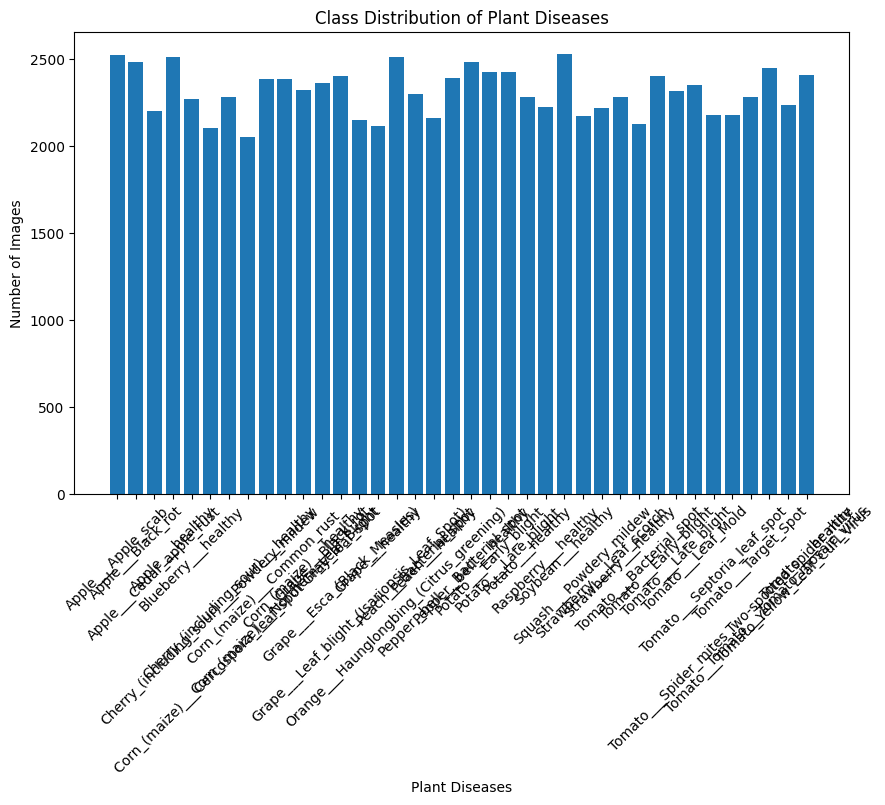

In [3]:
# Set base directory for data
base_dir = '/content/drive/MyDrive/PlantDiseases/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/'

# Function to check and visualize image distribution
def plot_class_distribution(directory):
    class_counts = {}
    for split in ['train', 'valid']:
        split_dir = os.path.join(directory, split)
        for class_name in os.listdir(split_dir):
            class_path = os.path.join(split_dir, class_name)
            if os.path.isdir(class_path):
                if class_name not in class_counts:
                    class_counts[class_name] = 0
                class_counts[class_name] += len(os.listdir(class_path))

    plt.figure(figsize=(10, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution of Plant Diseases')
    plt.xlabel('Plant Diseases')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

plot_class_distribution(base_dir)


#Image Segmentation (Using Color Thresholding in HSV Space)

In [4]:
# Image Segmentation: Use Color Thresholding (Simple Approach with HSV)
def segment_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to open image {image_path}")
        return None

    # Convert to HSV color space
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Define color range for green (adjust if needed for plant leaves)
    lower_green = np.array([25, 40, 40])
    upper_green = np.array([85, 255, 255])

    # Create a mask for the green parts of the image
    mask = cv2.inRange(hsv, lower_green, upper_green)

    # Segment the plant from the background
    segmented = cv2.bitwise_and(image, image, mask=mask)

    return segmented


#Segmentation Validation (Visualizing Segmentation Results)

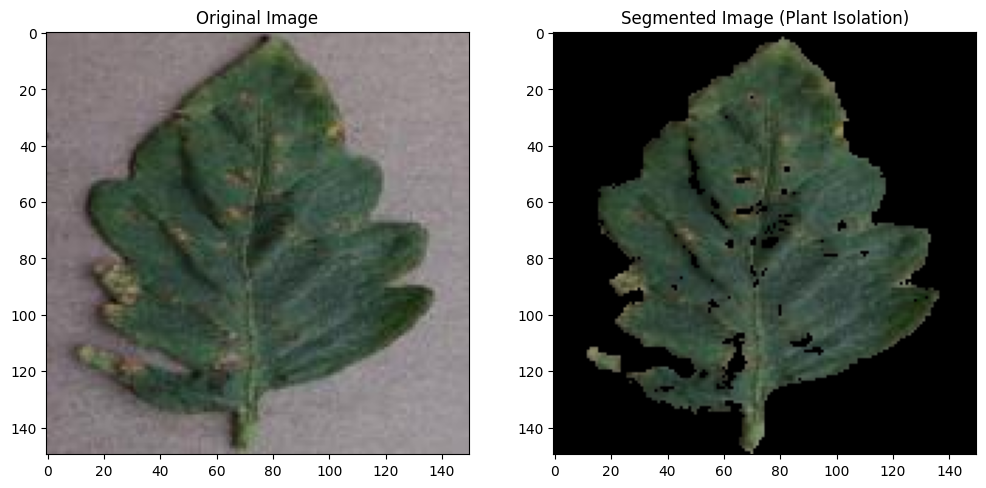

In [5]:
# Segmentation Validation: Visualize segmentation results
def validate_segmentation(image_path):
    original_image = cv2.imread(image_path)
    segmented_image = segment_image(image_path)

    if segmented_image is not None:
        plt.figure(figsize=(12, 6))

        # Original Image
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")

        # Segmented Image
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
        plt.title("Segmented Image (Plant Isolation)")

        plt.show()

# Example of segmentation and validation
image_sample_path = os.path.join(base_dir, 'train', 'Tomato___Bacterial_spot', '0ab9c705-f29e-45ac-b786-9549b3c38f16___GCREC_Bact.Sp 3223.JPG')
validate_segmentation(image_sample_path)


#Feature Extraction (Texture, Color, Shape)

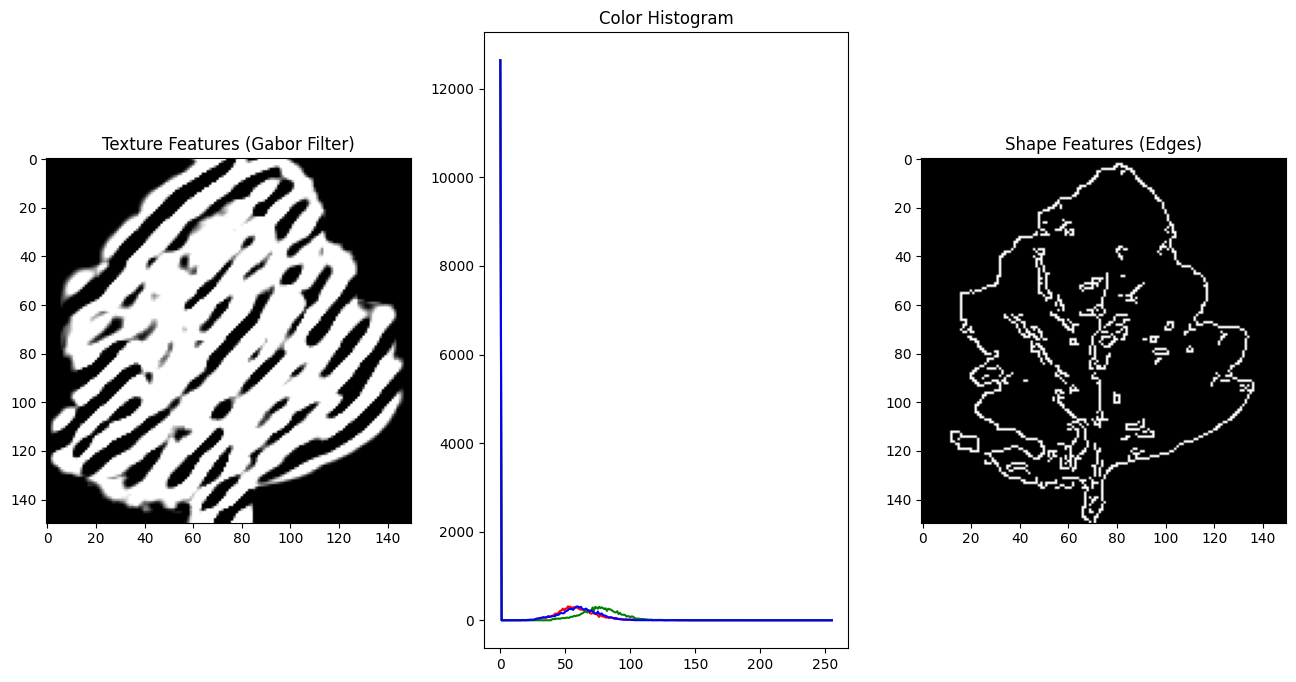

In [6]:
# Feature Extraction: Texture, Color, and Shape Features
def extract_features(image_path):
    image = segment_image(image_path)
    if image is None:
        return None

    # Convert to grayscale for texture analysis
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 1. Texture Features: Use Gabor filter to capture texture
    gabor_kernel = cv2.getGaborKernel((21, 21), 8.0, np.pi / 4, 10.0, 0.5, 0, cv2.CV_32F)
    texture_features = cv2.filter2D(gray_image, cv2.CV_8UC3, gabor_kernel)

    # 2. Color Features: Calculate color histograms for each channel
    hist_b = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256])
    hist_r = cv2.calcHist([image], [2], None, [256], [0, 256])

    # 3. Shape Features: Use Canny Edge detection to capture edges (plant shape)
    edges = cv2.Canny(gray_image, 100, 200)

    # Visualization of features
    plt.figure(figsize=(16, 8))

    # Texture Feature
    plt.subplot(1, 3, 1)
    plt.imshow(texture_features, cmap='gray')
    plt.title('Texture Features (Gabor Filter)')

    # Color Features (Histogram)
    plt.subplot(1, 3, 2)
    plt.plot(hist_r, color='r')
    plt.plot(hist_g, color='g')
    plt.plot(hist_b, color='b')
    plt.title('Color Histogram')

    # Shape Features (Edges)
    plt.subplot(1, 3, 3)
    plt.imshow(edges, cmap='gray')
    plt.title('Shape Features (Edges)')

    plt.show()

# Example of feature extraction
extract_features(image_sample_path)


In [7]:
# Create a DataFrame to hold features and labels
train_dir = os.path.join(base_dir, 'train')
feature_data = []

def extract_features_and_store(image_path, label):
    image = segment_image(image_path)
    if image is None:
        return None

    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Extracting features (can include more features as needed)
    hist_b = cv2.calcHist([image], [0], None, [256], [0, 256]).flatten()
    hist_g = cv2.calcHist([image], [1], None, [256], [0, 256]).flatten()
    hist_r = cv2.calcHist([image], [2], None, [256], [0, 256]).flatten()

    features = np.hstack((hist_r, hist_g, hist_b))
    feature_data.append((features, label))

# Process all images to extract features
def process_all_images_for_features(directory):
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                if img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
                    extract_features_and_store(img_path, class_name)

# Call the function to extract features for all images
process_all_images_for_features(train_dir)

# Convert to DataFrame
features_df = pd.DataFrame(feature_data, columns=['Features', 'Label'])


In [8]:
features_df.head(50)

,Features,Label
0,"[12147.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",Apple___Apple_scab
1,"[9833.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",Apple___Apple_scab
2,"[9279.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",Apple___Apple_scab
3,"[12131.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",Apple___Apple_scab
4,"[12092.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",Apple___Apple_scab
5,"[9339.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",Apple___Apple_scab
6,"[14757.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",Apple___Apple_scab
7,"[14752.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",Apple___Apple_scab
8,"[14783.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",Apple___Apple_scab
9,"[8981.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0....",Apple___Apple_scab


In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define image dimensions and batch size
img_height, img_width = 128, 128  # Resize images to a uniform size
batch_size = 32

# Create an ImageDataGenerator for training with data augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,   # Normalize pixel values between 0 and 1
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Create an ImageDataGenerator for validation without augmentation
valid_datagen = ImageDataGenerator(rescale=1.0/255)

# Load training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

# Load validation data
valid_generator = valid_datagen.flow_from_directory(
    os.path.join(base_dir, 'valid'),
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 70295 images belonging to 38 classes.
Found 17572 images belonging to 38 classes.


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Define CNN architecture
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer for multi-class classification
])

# Compile the model
cnn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
# Set the number of epochs
epochs = 5
# Train the model
history = cnn_model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator
)


Epoch 1/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 3783s 2s/step - accuracy: 0.5258 - loss: 1.5649 - val_accuracy: 0.7090 - val_loss: 0.9445
Epoch 2/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2834s 1s/step - accuracy: 0.6279 - loss: 1.2020 - val_accuracy: 0.7460 - val_loss: 0.8117
Epoch 3/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2863s 1s/step - accuracy: 0.6810 - loss: 1.0273 - val_accuracy: 0.8574 - val_loss: 0.4544
Epoch 4/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2907s 1s/step - accuracy: 0.7187 - loss: 0.9010 - val_accuracy: 0.8802 - val_loss: 0.3916
Epoch 5/5
2197/2197 ━━━━━━━━━━━━━━━━━━━━ 2900s 1s/step - accuracy: 0.7456 - loss: 0.8064 - val_accuracy: 0.8685 - val_loss: 0.4051


In [13]:
# Evaluate on validation data
val_loss, val_accuracy = cnn_model.evaluate(valid_generator)
print(f"Validation Accuracy: {val_accuracy:.2f}")
print(f"Validation Loss: {val_loss:.2f}")


550/550 ━━━━━━━━━━━━━━━━━━━━ 213s 387ms/step - accuracy: 0.8697 - loss: 0.4000
Validation Accuracy: 0.87
Validation Loss: 0.41


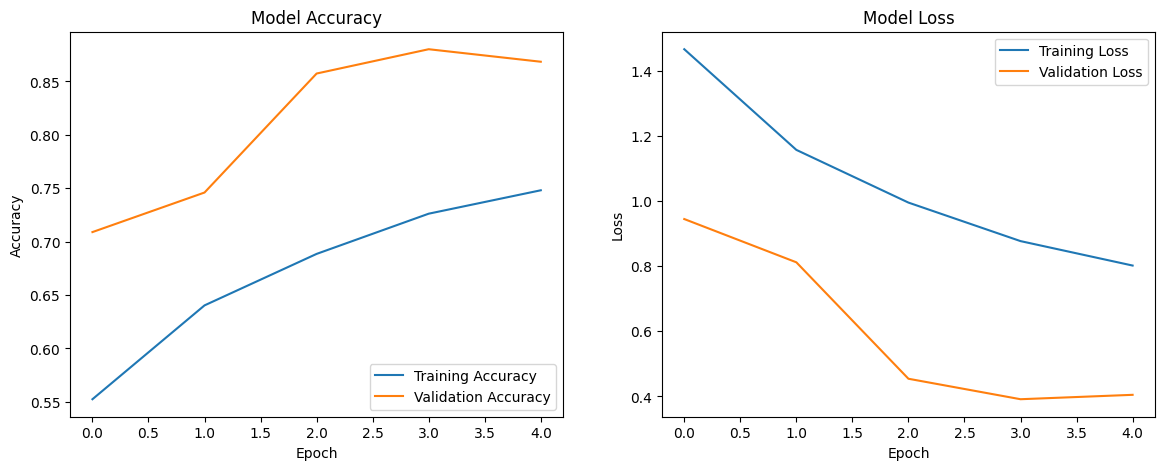

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(14, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()


In [17]:
# Save the trained model
cnn_model_path = '/content/drive/MyDrive/PlantDiseaseModel/cnn_plant_disease_model.keras'
cnn_model.save(cnn_model_path)
print(f"CNN model saved to {cnn_model_path}")


CNN model saved to /content/drive/MyDrive/PlantDiseaseModel/cnn_plant_disease_model.keras


In [21]:
from tensorflow.keras.models import load_model
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the saved model
loaded_cnn_model = load_model(cnn_model_path)

# Prediction on a sample image
def predict_image_class(img_path, model):
    img = image.load_img(img_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0,1]
    img_array = np.expand_dims(img_array, axis=0)  # Expand dims for batch

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    class_labels = train_generator.class_indices  # Mapping of labels
    label_map = {v: k for k, v in class_labels.items()}  # Reverse mapping
    return label_map[predicted_class[0]]

# Example of prediction
sample_image_path = os.path.join(base_dir, 'valid', 'Grape___Black_rot', '0aff8add-93ad-4099-97ae-23515744e620___FAM_B.Rot 0748_flipLR.JPG')
print("Predicted Class:", predict_image_class(sample_image_path, loaded_cnn_model))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
Predicted Class: Grape___Black_rot


550/550 ━━━━━━━━━━━━━━━━━━━━ 248s 450ms/step


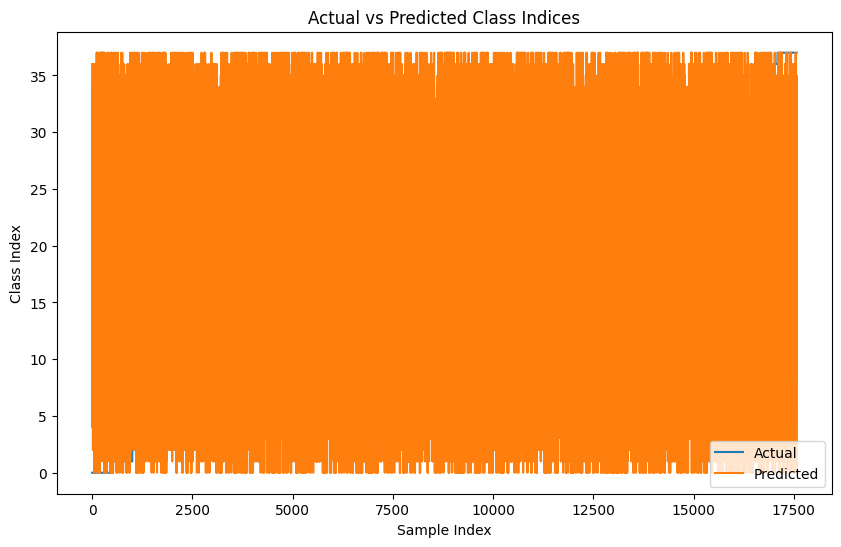

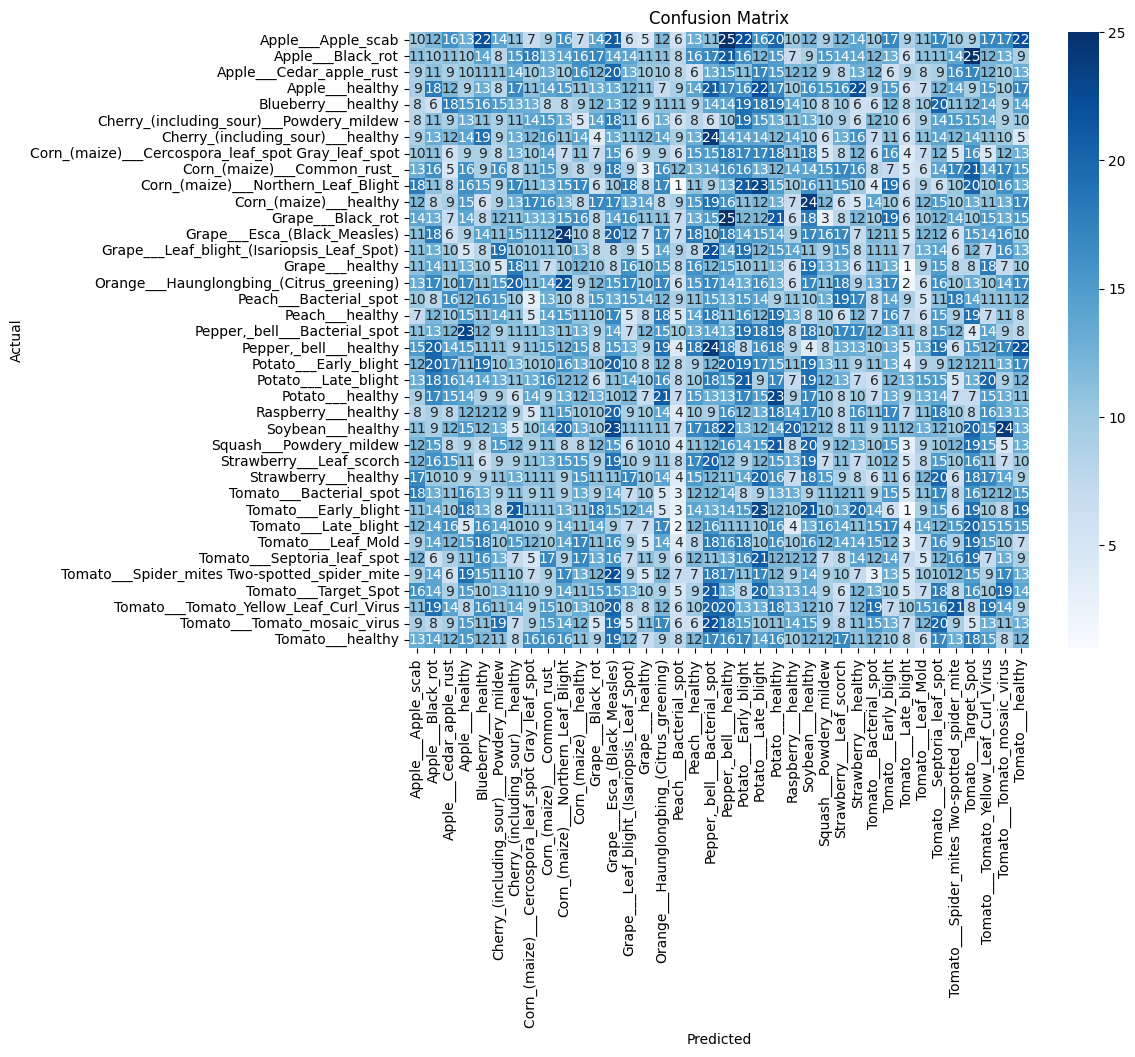

In [23]:


# Get the predicted probabilities for validation data
y_pred_prob = loaded_cnn_model.predict(valid_generator)

# Get the predicted classes (indices of the highest probability)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get the true classes from the validation generator
y_true = valid_generator.classes

# Get the class labels (mapping from index to label)
class_labels = list(valid_generator.class_indices.keys())

# Plot the actual vs predicted results
plt.figure(figsize=(10, 6))
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample Index')
plt.ylabel('Class Index')
plt.title('Actual vs Predicted Class Indices')
plt.legend()
plt.show()

# You can also create a confusion matrix for a more detailed analysis
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix (optional)
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

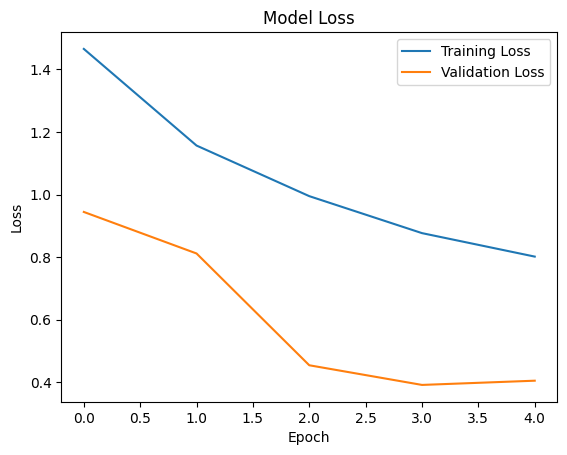

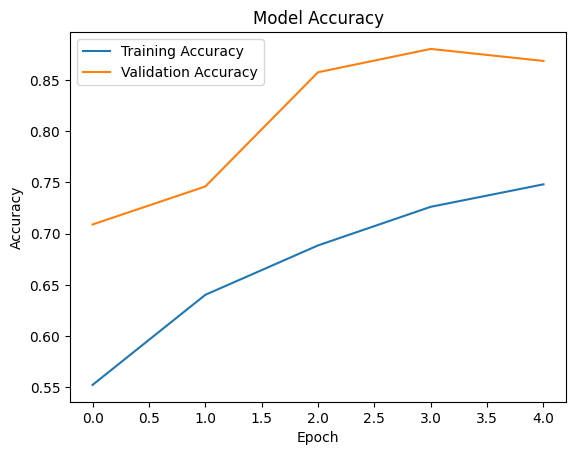

In [24]:


# Plot the training and validation loss over epochs
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [27]:
# Get class indices from the training generator
class_labels = train_generator.class_indices

# Invert the dictionary to map indices to class names
class_names = {v: k for k, v in class_labels.items()}

print(class_names)  # This will display the index-to-class mapping


{0: 'Apple___Apple_scab', 1: 'Apple___Black_rot', 2: 'Apple___Cedar_apple_rust', 3: 'Apple___healthy', 4: 'Blueberry___healthy', 5: 'Cherry_(including_sour)___Powdery_mildew', 6: 'Cherry_(including_sour)___healthy', 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 8: 'Corn_(maize)___Common_rust_', 9: 'Corn_(maize)___Northern_Leaf_Blight', 10: 'Corn_(maize)___healthy', 11: 'Grape___Black_rot', 12: 'Grape___Esca_(Black_Measles)', 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 14: 'Grape___healthy', 15: 'Orange___Haunglongbing_(Citrus_greening)', 16: 'Peach___Bacterial_spot', 17: 'Peach___healthy', 18: 'Pepper,_bell___Bacterial_spot', 19: 'Pepper,_bell___healthy', 20: 'Potato___Early_blight', 21: 'Potato___Late_blight', 22: 'Potato___healthy', 23: 'Raspberry___healthy', 24: 'Soybean___healthy', 25: 'Squash___Powdery_mildew', 26: 'Strawberry___Leaf_scorch', 27: 'Strawberry___healthy', 28: 'Tomato___Bacterial_spot', 29: 'Tomato___Early_blight', 30: 'Tomato___Late_blight', 31: 'To